In [3]:
import torch
import numpy as np
from ademamix import AdEMAMix
from lion import Lion
from focus import FOCUS

seed = 7
torch.manual_seed(seed)
np.random.seed(seed)

# get task vectors. all orthogonal
dim = 5
n_task = 40

# n_task = 10 can easily see why AdEMAMix accelerates with old momentum

gaus = torch.randn(dim, dim)
#u, s, v = torch.svd(gaus)

'''u = torch.randn(2, dim)/torch.sqrt(torch.tensor(dim))
gamma = - 0.5
u[1] = u[1] + gamma * u[0] '''


# sweep noise scale is the most important 
# Lion performs worse when noise is large

# power law distribution
alpha = 2
prob = 1/(np.arange(n_task) + 1)**(alpha)
prob /= np.sum(prob)

'''prob1 = 0.9
prob = [prob1] + list(prob * (1-prob1))
prob = np.array(prob)
n_task += 1'''

noise_scale = 0.0 # maybe due to non-linearity

u = torch.randn(n_task, dim)
u = u/torch.norm(u, dim=1, keepdim=True)
task_vectors = u[:n_task]


batch_size = 1024

# initial and target
x = torch.nn.Parameter(torch.zeros(dim,))

learning_rate = 0.01
#optimizer = torch.optim.SGD([x], lr=learning_rate)
optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
#optimizer = AdEMAMix([x], lr=learning_rate)
#optimizer = FOCUS([x], lr=learning_rate, gamma=0.1)
#optimizer = Lion([x], lr=learning_rate)
target = torch.sum(task_vectors, dim=0)


n_steps = 5000
log = 1000
task_abilities = []
losses = []
losses_skill = []
n_uses = []


for i in range(n_steps):
    
    '''if i == 5000:
        for g in optimizer.param_groups:
            g['lr'] = 0.006 #0.003
            noise_scale = 0.0 #0.0
        #batch_size = 512
    if i == 6000:
        for g in optimizer.param_groups:
            g['lr'] = 0.01
            noise_scale = 0.1'''
    
    '''if i < 100:
        for g in optimizer.param_groups:
            g['lr'] = 0.01/100 * (i+1)'''

    optimizer.zero_grad()

    # project and get progress
    task_overlap = task_vectors @ x
    task_ability = torch.sigmoid(task_overlap)
    
    loss = np.sum(-np.log(task_ability.detach().numpy()) * prob)
    task_abilities.append(task_ability.detach().numpy())
    losses.append(loss)
    losses_skill.append(1 - task_ability.detach().numpy())

    # mimic gradient
    id = np.random.choice(n_task, batch_size, p=prob)
    task_vectors_batch = task_vectors[id]
    task_ability_batch = task_ability[id]
    
    #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
    #neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

    #neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
    loss_per_sample = -torch.log(task_ability_batch)
    
    if i < 20000:
        loss = torch.mean(loss_per_sample)
    else:
        loss = torch.mean(loss_per_sample * (0.1+loss_per_sample.detach())**(-0.5))
    loss.backward()
    x.grad.data += noise_scale * torch.randn(dim,)
    
    # update 
    #x.grad = - neg_grad + torch.randn(dim) * noise_scale
    optimizer.step()
    
    neg_grad = - x.grad.detach()
    
    # compute #(used dimension)
    alignment = task_vectors * neg_grad[None, :] > 0
    n_used = torch.sum(alignment, dim=1)
    n_uses.append(n_used.detach().numpy())
    
    if i % log == 0:
        print(i)

task_abilities = np.array(task_abilities)
losses = np.array(losses)
n_uses = np.array(n_uses)
losses_skill = np.array(losses_skill)

0
1000
2000
3000
4000


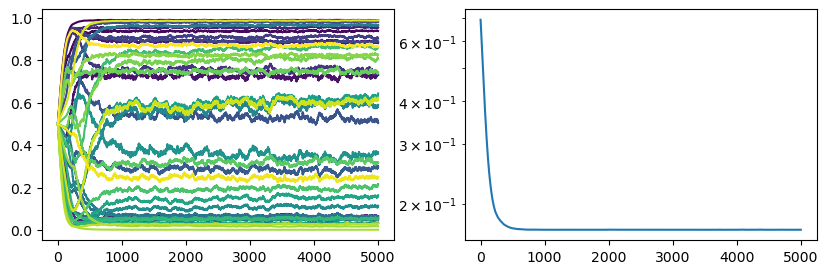

In [4]:
import matplotlib.pyplot as plt
import copy

plt.figure(figsize=(10,3))

cmap = plt.get_cmap('viridis') 

plt.subplot(1,2,1)

for i in range(n_task):
    plt.plot(task_abilities[:,i], color=cmap(i/(n_task-1)))
    
#plt.legend(np.arange(n_task))
    
#plt.xlim(1,300)
#plt.xscale('log')

plt.subplot(1,2,2)

losses1 = copy.deepcopy(losses)
plt.plot(losses1)
#plt.xscale('log')
plt.yscale('log')

task_abilities1 = copy.deepcopy(task_abilities)

In [61]:
Cij = (task_vectors @ task_vectors.T).detach().numpy()

In [62]:
import copy

#cmap = plt.get_cmap('viridis') 

l = np.zeros(n_task,)

lr = 4 * learning_rate * np.sqrt(dim)
n_steps2 = 5000

ls = []
losses = []

# Why is loss so small?

def sigmoid(x):
    return 1/(1+np.exp(-x))

for i in range(n_steps2):
    fg = prob * np.exp(-l)/(1+np.exp(-l))
    nominator = (Cij @ fg[:,None])[:,0]
    fg_norm = nominator/(np.sum(fg) + 0.00)
    l += lr * fg_norm
    ls.append(copy.deepcopy(l))
    
    loss = np.sum(prob * np.log(1+np.exp(-l)))
    losses.append(loss)
    
ls = np.array(ls)

losses = np.array(losses)

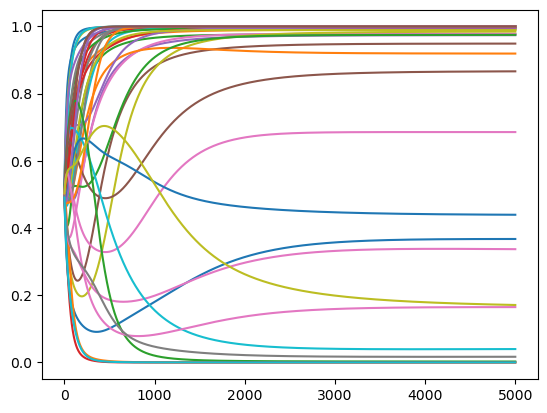

In [63]:
for i in range(n_task):
    plt.plot(sigmoid(ls[:,i]))

In [1]:


import torch
import numpy as np
import copy



n_tasks = [5,10,20,40,100]

results = {}

for n_task in n_tasks:
    
    print('n_task=', n_task)
    
    seed = 7
    torch.manual_seed(seed)
    np.random.seed(seed)

    # get task vectors. all orthogonal
    dim = 10
    #n_task = 40

    # n_task = 10 can easily see why AdEMAMix accelerates with old momentum

    gaus = torch.randn(dim, dim)
    #u, s, v = torch.svd(gaus)

    '''u = torch.randn(2, dim)/torch.sqrt(torch.tensor(dim))
    gamma = - 0.5
    u[1] = u[1] + gamma * u[0] '''


    # sweep noise scale is the most important 
    # Lion performs worse when noise is large

    # power law distribution
    alpha = 2
    prob = 1/(np.arange(n_task) + 1)**(alpha)
    prob /= np.sum(prob)

    '''prob1 = 0.9
    prob = [prob1] + list(prob * (1-prob1))
    prob = np.array(prob)
    n_task += 1'''

    noise_scale = 0.0 # maybe due to non-linearity

    u = torch.randn(n_task, dim)
    u = u/torch.norm(u, dim=1, keepdim=True)
    task_vectors = u[:n_task]


    batch_size = 1024

    # initial and target
    x = torch.nn.Parameter(torch.zeros(dim,))

    learning_rate = 0.01
    #optimizer = torch.optim.SGD([x], lr=learning_rate)
    optimizer = torch.optim.Adam([x], lr=learning_rate, betas=(0.0,0.0))
    #optimizer = AdEMAMix([x], lr=learning_rate)
    #optimizer = FOCUS([x], lr=learning_rate, gamma=0.1)
    #optimizer = Lion([x], lr=learning_rate)
    target = torch.sum(task_vectors, dim=0)


    n_steps = 3000
    log = 1000
    task_abilities = []
    losses = []
    losses_skill = []
    n_uses = []


    for i in range(n_steps):

        '''if i == 5000:
            for g in optimizer.param_groups:
                g['lr'] = 0.006 #0.003
                noise_scale = 0.0 #0.0
            #batch_size = 512
        if i == 6000:
            for g in optimizer.param_groups:
                g['lr'] = 0.01
                noise_scale = 0.1'''

        '''if i < 100:
            for g in optimizer.param_groups:
                g['lr'] = 0.01/100 * (i+1)'''

        optimizer.zero_grad()

        # project and get progress
        task_overlap = task_vectors @ x
        task_ability = torch.sigmoid(task_overlap)

        loss = np.sum(-np.log(task_ability.detach().numpy()) * prob)
        task_abilities.append(task_ability.detach().numpy())
        losses.append(loss)
        losses_skill.append(1 - task_ability.detach().numpy())

        # mimic gradient
        id = np.random.choice(n_task, batch_size, p=prob)
        task_vectors_batch = task_vectors[id]
        task_ability_batch = task_ability[id]

        #neg_grad_per_sample = (1-task_ability_batch).unsqueeze(dim=1)
        #neg_grad_per_sample = torch.abs(1-task_ability_batch).unsqueeze(dim=1) ** (1) * torch.sign((1-task_ability_batch).unsqueeze(dim=1))

        #neg_grad = torch.mean(task_vectors_batch*neg_grad_per_sample, dim=0)
        loss_per_sample = -torch.log(task_ability_batch)

        if i < 20000:
            loss = torch.mean(loss_per_sample)
        else:
            loss = torch.mean(loss_per_sample * (0.1+loss_per_sample.detach())**(-0.5))
        loss.backward()
        x.grad.data += noise_scale * torch.randn(dim,)

        # update 
        #x.grad = - neg_grad + torch.randn(dim) * noise_scale
        optimizer.step()

        neg_grad = - x.grad.detach()

        # compute #(used dimension)
        alignment = task_vectors * neg_grad[None, :] > 0
        n_used = torch.sum(alignment, dim=1)
        n_uses.append(n_used.detach().numpy())

        if i % log == 0:
            print(i)

    task_abilities = np.array(task_abilities)
    losses = np.array(losses)
    n_uses = np.array(n_uses)
    losses_skill = np.array(losses_skill)

    results[f"exp_{n_task}"] = task_abilities

    Cij = (task_vectors @ task_vectors.T).detach().numpy()


    import copy

    #cmap = plt.get_cmap('viridis') 

    l = np.zeros(n_task,)

    lr = 4 * learning_rate * np.sqrt(dim)
    n_steps2 = 3000

    ls = []
    losses = []

    # Why is loss so small?

    def sigmoid(x):
        return 1/(1+np.exp(-x))

    for i in range(n_steps2):
        fg = prob * np.exp(-l)/(1+np.exp(-l))
        nominator = (Cij @ fg[:,None])[:,0]
        fg_norm = nominator/(np.sum(fg) + 0.00)
        l += lr * fg_norm
        ls.append(copy.deepcopy(l))

        loss = np.sum(prob * np.log(1+np.exp(-l)))
        losses.append(loss)

    ls = np.array(ls)

    results[f"theory_{n_task}"] = sigmoid(ls)

n_task= 5
0
1000
2000
n_task= 10
0
1000
2000
n_task= 20
0
1000
2000
n_task= 40
0
1000
2000
n_task= 100
0
1000
2000


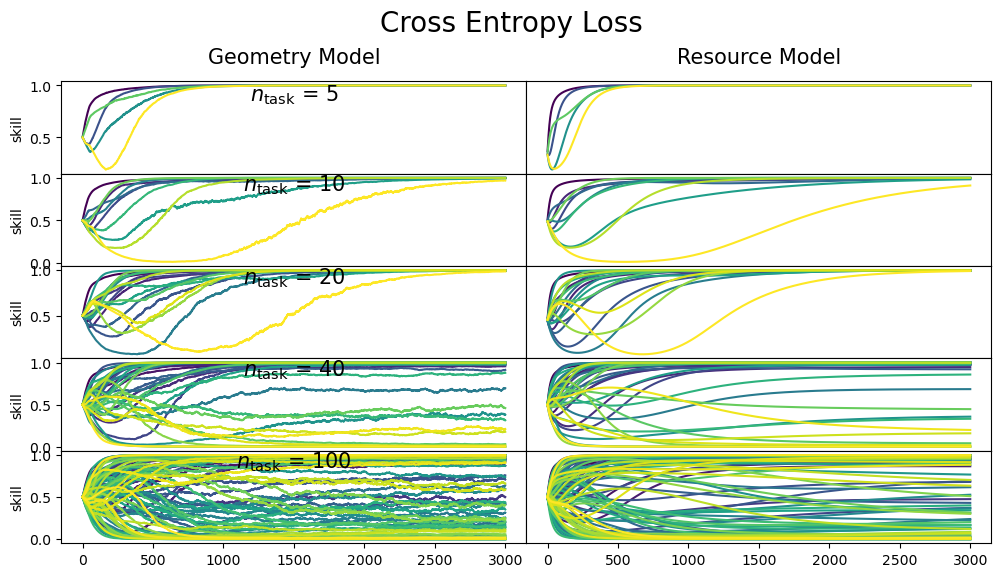

In [2]:
import matplotlib.pyplot as plt

ii = 0

plt.figure(figsize=(12,6))

cmap = plt.get_cmap('viridis') 

n_tasks = [5,10,20,40,100]

for n_task in n_tasks:

    theory = results[f'theory_{n_task}']
    experiment = results[f'exp_{n_task}']

    plt.subplot(5,2,2*ii+1)

    for i in range(n_task):
        plt.plot(experiment[:,i], color=cmap(i/(n_task-1)))
        

    #plt.ylim(-0.05,1.3)
    
    plt.ylabel('skill', fontsize=10)
    
    x0 = 1500
    y0 = 0.85
    
    plt.text(x0, y0, r"$n_{\rm task}$ = "+str(n_task), fontsize = 15, horizontalalignment='center')
    
    if ii == 3:
        plt.xlabel('training steps', fontsize=10)
        
    if ii == 0:
        plt.title('Geometry Model', fontsize=15, y=1.1)

    plt.subplot(5,2,2*ii+2)

    for i in range(n_task):
        plt.plot(theory[:,i], color=cmap(i/(n_task-1)))
        
        
    #plt.text(x0, y0, r"$N_0$ = "+"0.01", fontsize = 12, horizontalalignment='center')
        
    plt.yticks([])
    
    if ii == 0:
        plt.title('Resource Model', fontsize=15, y=1.1)
    
    #plt.ylim(-0.05,1.3)
    
    if ii == 3:
        plt.xlabel('training steps', fontsize=10)
        
    ii += 1
    
plt.suptitle('Cross Entropy Loss', fontsize=20, y=1.0)
        
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('./plot/underparam_ce.pdf', bbox_inches='tight')